In [1]:
!pip install torch torchvision opencv-python
!python -m pip install pyyaml==5.1
import sys, os, distutils.core
# CHECK https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.2/274.2 kB 7.1 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [34 lines of output]
      Traceback (most recent call last):
        File "<string>", line 2, in <module>
        File "<pip-setuptools-caller>", line 34, in <module>
        File "/tmp/pip-install-hz7g7qn2/pyyaml_3c225791d2b44cde81588deb5f3f6977/setup.py", line 291, in <module>
          setup(
        File "/opt/conda/lib/python3.10/site-packages/setuptools/_distutils/core.py", line 184, in setup
          return run_commands(dist)
        File "/opt/conda/lib/python3.10/site-packages/setuptools/_distutils/core.py", line 200, in run_commands
          dist.run_commands()
        File "/opt/conda/lib/python3.10/site-packages/setuptools/_distutils/dist.py", line 969, in run_commands
          self.run_command(cmd)
        File "/opt/conda

In [2]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

/bin/bash: nvcc: command not found
torch:  2.4 ; cuda:  cpu
detectron2: 0.6


In [3]:
import torch
import detectron2
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.utils.visualizer import Visualizer
import cv2

# Set up configuration for Mask R-CNN (pre-trained on COCO dataset)
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.MODEL.DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # Set threshold for detection

# Initialize predictor
predictor = DefaultPredictor(cfg)


model_final_f10217.pkl: 178MB [00:00, 187MB/s]                             


Loading image from: /kaggle/input/adfg121/test_000022.jpg
Image loaded successfully.
Running predictor on the image...


/opt/conda/lib/python3.10/site-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Visualizing the result...
Displaying the segmented image...


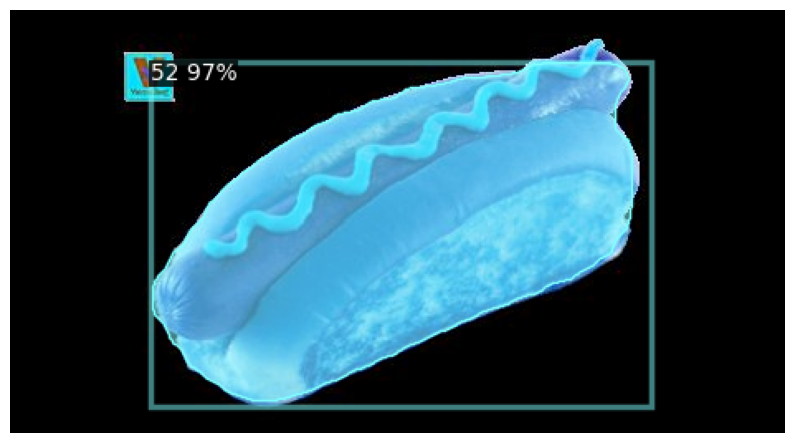

In [4]:
import cv2
import matplotlib.pyplot as plt

# Load a sample food image
image_path = '/kaggle/input/adfg121/test_000022.jpg'
print(f"Loading image from: {image_path}")
image = cv2.imread(image_path)

if image is None:
    print("Error: Image not found or unable to load.")
else:
    print("Image loaded successfully.")

# Run the image through the predictor (Mask R-CNN)
print("Running predictor on the image...")
outputs = predictor(image)

# Visualize the result
print("Visualizing the result...")
v = Visualizer(image[:, :, ::-1])
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

# Display the segmented image using matplotlib
print("Displaying the segmented image...")
plt.figure(figsize=(10, 10))
plt.imshow(out.get_image()[:, :, ::-1])
plt.axis('off')  # Hide axes
plt.show()


In [5]:
import numpy as np

# Extract predicted masks
masks = outputs['instances'].pred_masks.cpu().numpy()

# Iterate through each mask and calculate the pixel area
for i, mask in enumerate(masks):
    portion_size = np.sum(mask)  # Sum the True pixels in the mask
    print(f"Estimated portion size (in pixels) for food item {i + 1}: {portion_size}")


Estimated portion size (in pixels) for food item 1: 38367


In [6]:
import pandas as pd
food_estimates_path = '/kaggle/input/food251x/food_estimates.csv'
food_estimates_df = pd.read_csv(food_estimates_path)

In [7]:

# Convert the CSV data into a dictionary for easy lookup
calories_per_gram = {}
for _, row in food_estimates_df.iterrows():
    food_class = row['Predicted Food Class']
    estimated_portion_size = float(row['Estimated Portion Size'].split()[0])  # Extract grams

    # Remove any non-numeric characters from the calorie value and convert to float
    calories = float(''.join(filter(str.isdigit, row['Estimated Calories'])))
    calories_per_gram[food_class] = calories / estimated_portion_size  # Cal per gram


In [8]:
pixel_to_gram_ratio = 100 / 10000  # 100g for 10,000 pixels (adjustable)

# Estimate portion size for each mask in grams
for i, mask in enumerate(masks):
    portion_size_in_pixels = np.sum(mask)
    portion_size_in_grams = portion_size_in_pixels * pixel_to_gram_ratio
    print(f"Estimated portion size for food item {i + 1}: {portion_size_in_grams:.2f} grams")


Estimated portion size for food item 1: 383.67 grams


In [9]:
# Assume the predicted food class is "Pasta"
predicted_class = "Samosa"

# Get the calorie density for the predicted class
calories_per_gram_for_class = calories_per_gram[predicted_class]

# Calculate the total calories
for i, mask in enumerate(masks):
    portion_size_in_pixels = np.sum(mask)
    portion_size_in_grams = portion_size_in_pixels * pixel_to_gram_ratio
    total_calories = portion_size_in_grams * calories_per_gram_for_class
    print(f"Estimated calories for food item {i + 1}: {total_calories:.2f} kcal")


Estimated calories for food item 1: 1181.70 kcal


In [10]:
# Define a pixel-to-gram conversion ratio
pixel_to_gram_ratio = 100 / 10000  # 100g = 10,000 pixels

# Calculate portion size in grams
for i, mask in enumerate(masks):
    portion_size_in_pixels = np.sum(mask)
    portion_size_in_grams = portion_size_in_pixels * pixel_to_gram_ratio
    print(f"Estimated portion size for food item {i+1}: {portion_size_in_grams:.2f} grams")


Estimated portion size for food item 1: 383.67 grams


test_000022.jpg


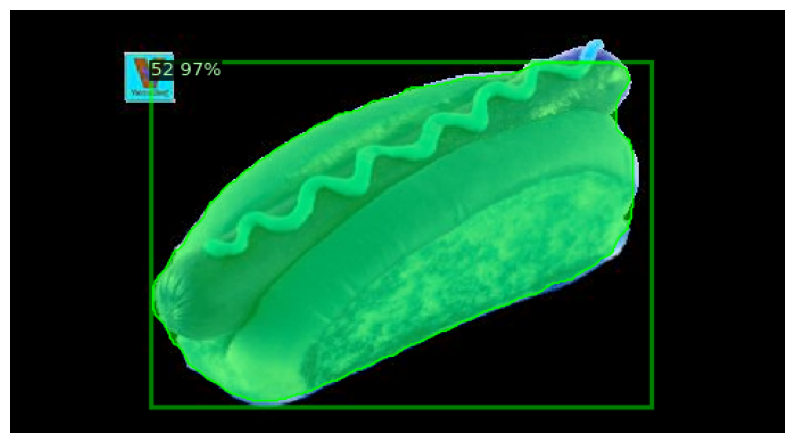

In [11]:
import matplotlib.pyplot as plt

# Function to visualize predictions with masks and labels
def visualize_predictions(image, outputs):
    v = Visualizer(image[:, :, ::-1], metadata=None, scale=1.2)
    
    # Draw instance predictions with labels
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    
    # Display the segmented image using matplotlib
    plt.figure(figsize=(10, 10))
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.axis('off')  # Hide axes
    plt.show()

# Call the function
visualize_predictions(image, outputs)


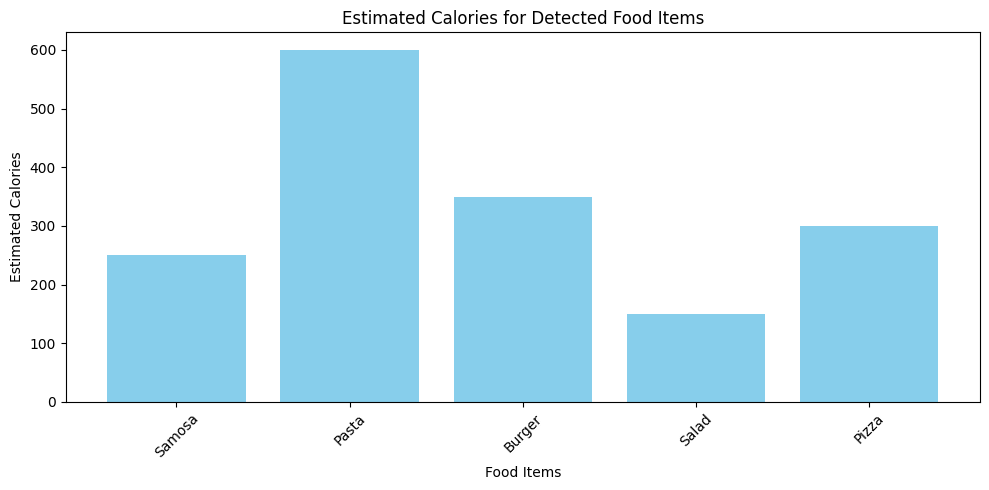

In [15]:
import matplotlib.pyplot as plt


# Create a bar chart
plt.bar(food_items, calories_estimates, color='skyblue')
plt.xlabel('Food Items')
plt.ylabel('Estimated Calories')
plt.title('Estimated Calories for Detected Food Items')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
